# House Prices - Advanced Regression Techniques 
    Desafio do Kaggle para prever Preço de Casas com Decision Tree Regressor
    
    Disponível em: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/

## Descrição da competição 

Peça a um comprador de casa para descrever a casa dos seus sonhos e provavelmente não começará com a altura do teto do porão ou a proximidade de uma ferrovia leste-oeste. Mas o conjunto de dados deste dataset da competição prova que muito mais influencia as negociações de preços do que o número de quartos ou uma cerca branca.

Com 79 variáveis explicativas que descrevem (quase) todos os aspectos das casas residenciais em Ames, Iowa, esta competição desafia você a **prever o preço final de cada casa**.

## Descrição do dataset 

Essa competição possui 4 arquivos disponíveis:

* *train.csv*: dataset de treino
* *test.csv*: dataset de teste 
* *data_description.txt*: arquivo com descrição completa de cada coluna
* *sample_submission.csv*: uma submissão de referência de uma regressão linear no ano e mês de venda, metragem quadrada do lote e o número de quartos. Apresenta ID e Sale Price (preço de venda) 

## Objetivo 
Prever o preço da venda de cada casa. Para cada ID do conjunto de teste deverá ser previsto o valor da variável SalePrice. 

Nesse notebook iremos utilizar **Árvores de Decisão** para prever o preço das casas.

In [1]:
# Importação das bibliotecas 
import pandas as pd
import numpy as np 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score
from scipy.stats import norm, skew

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Como importar dataset local do Kaggle 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
# Importando datasets de treino e teste
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
# Primeiros registros do dataset de treino
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Análise dos Dados 

In [6]:
# Tipo de variáveis do dataset de treino
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Aqui já podemos observar que em algumas colunas há *missing values* que teremos que tratar.

In [7]:
# Informações sobre os dados 
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
# Conferir se há dados duplicados 
train.duplicated().sum()

0

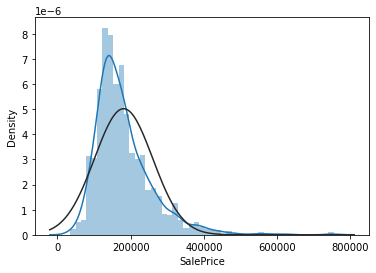

In [9]:
# Gráfico da variável target SalePrice
sns.distplot(train['SalePrice'], fit=norm);

O gráfico possui uma *inclinação positiva* que deve ser corrigida. 

Em estatística, com *Skewness* medimos o grau de assimetria observado em uma distribuiçao de probabilidade que se desvia da distribuição normal simétrica (curva de sino) em um determinado conjunto de dados, enquanto *Kurtosis* refere-se ao grau de presença de outliers na distribuição, e se os dados são de cauda pesada ou cauda leve em uma distribuição normal

In [10]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


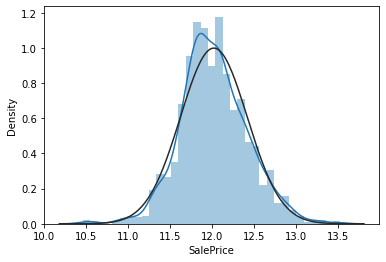

In [11]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm);

Agora podemos ver a distribuição da variável target (linha azul) mais próxima a uma distribuição normal (linha preta). 

<AxesSubplot:>

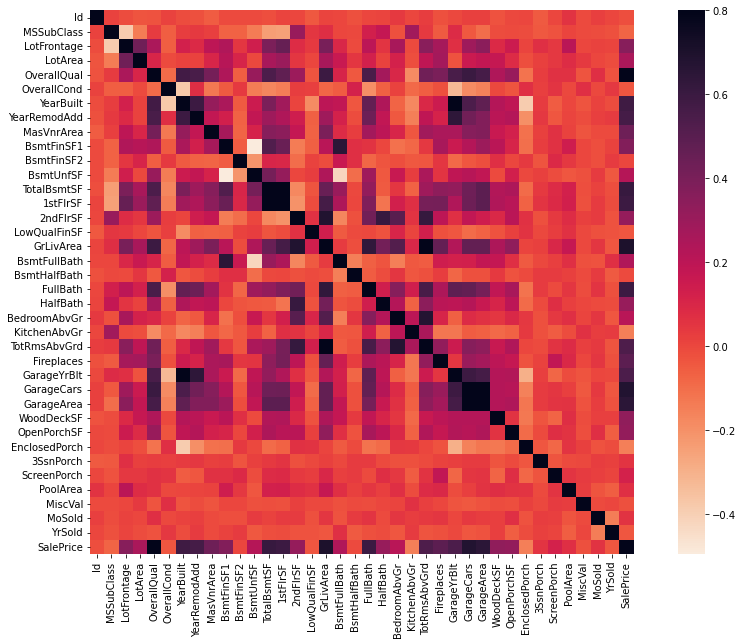

In [12]:
# Heatmap para observar as correações das variáveis 
plt.figure(figsize = (16,10))
sns.heatmap(train.corr(), vmax=.8, square = True, cmap = 'rocket_r')

As cores mais escuras indicadas no heatmap mostram as maiores correlações. 

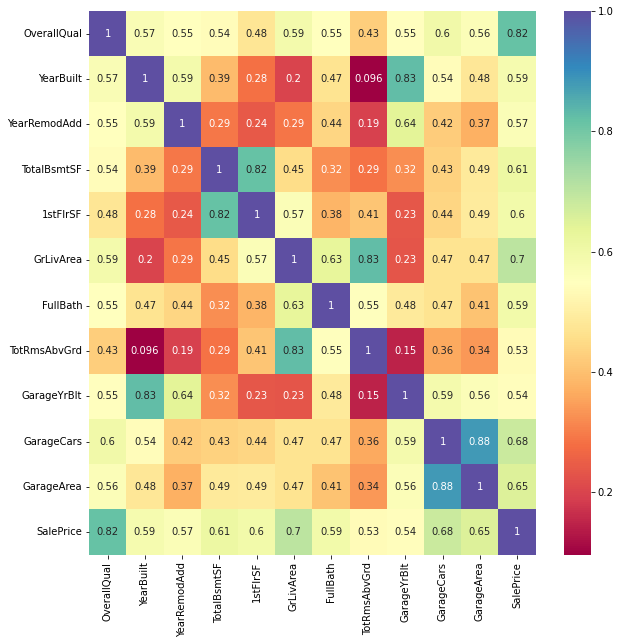

In [13]:
# Heatmap para vermos as features que possuem correlações mais altas com a variável target 
corr = train.corr()
maior_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[maior_corr_features].corr(),annot=True,cmap="Spectral")

Podemos observar que: 

* A feature *OverallQual* que indica a classificação geral da condição da casa está muito bem correlacionada com a variável target *SalePrice*;
* As features *YearBuilt* (ano de construção) e *GarageYrBlt* (ano de construção da garagem) são bem correlacionadas entre si;
* *TotalBsmtSF* (total de pés quadrados na área do porão) e *1stFlrSF* (medida do primeiro andar em pés quadrados) possuem boa correlação, com isso podemos manter qualquer um deles ou adicionar o *1stFlrSF* ao *TotalBsmtSF*  ;
* *GrLivArea* (área acima do nível (solo) em pés quadrados) e *TotRmsAbvGrd* (total de quartos acima do nível (não inclui banheiros) possuem boa correlação. Podemos manter apenas *GrLivArea* por ter melhor correlação com a variável target *SalePrice*;
* E as features *GarageCars* (tamanho da caragem em capacidade de carro) e *GarageArea* (tamanho da garam em pés quadrados) possuem a melhor correlação do dataset.

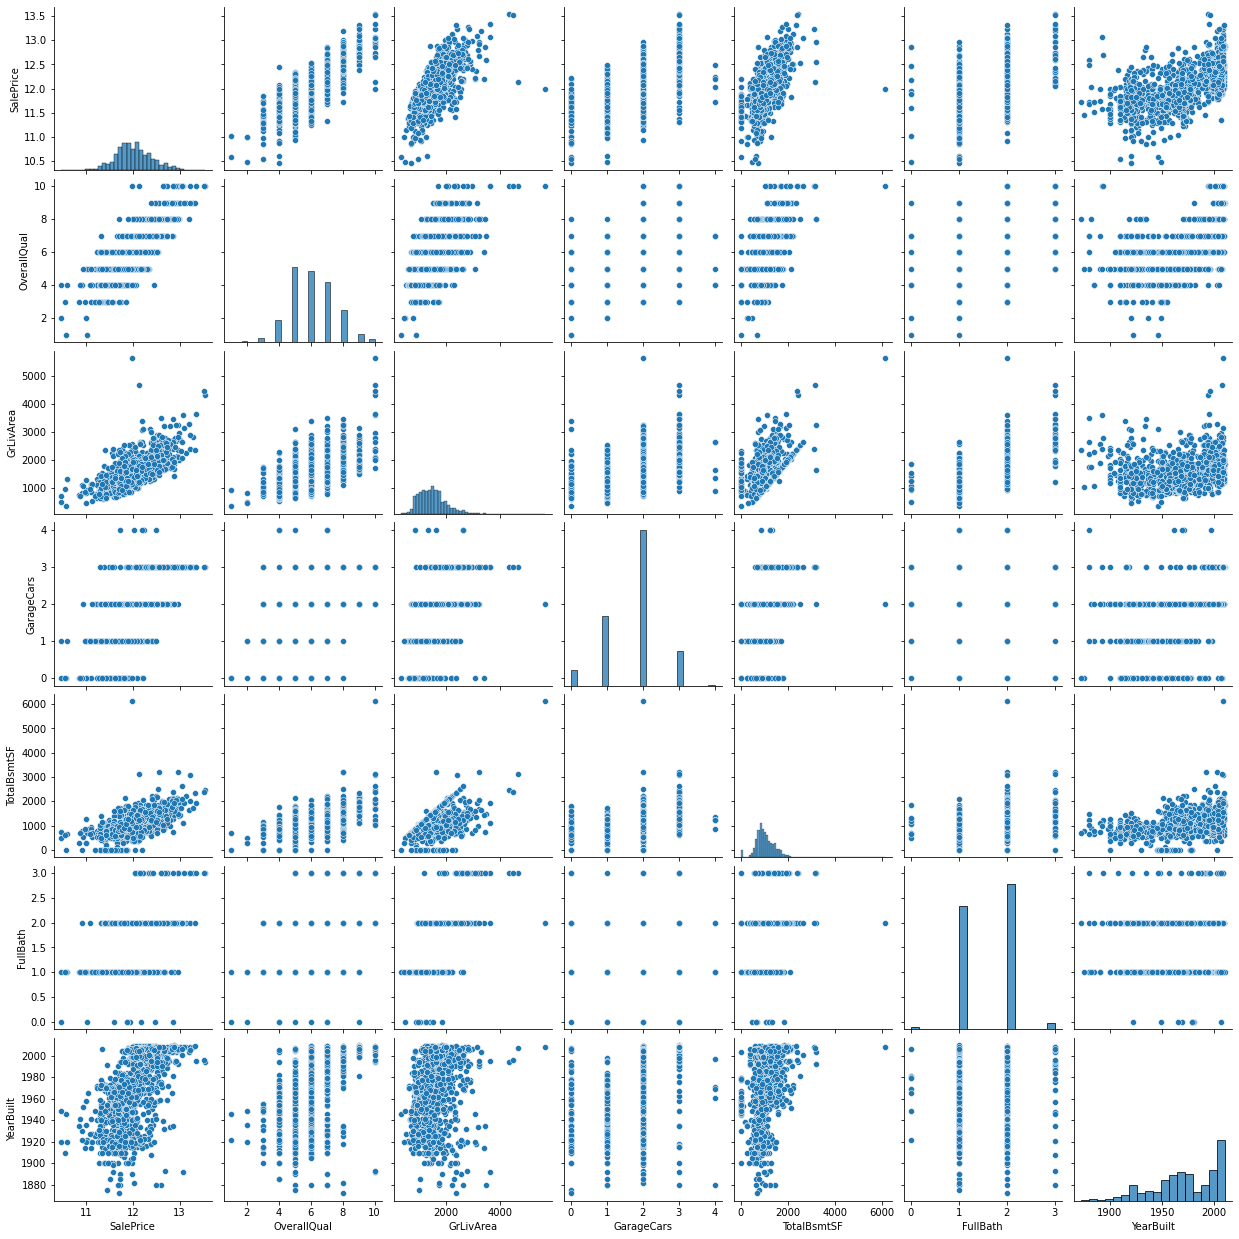

In [14]:
# Para observar as features que tem maior correlação 
col = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[col])

## Missing Values 

Antes de corrigir os missing values podemos concatenar os dataset de treino e teste, pré-processar os dados e depois dividi-los novamente. Assim, fica mais fácil de lidar com a preparação dos dados para o modelo. 

In [15]:
# Concatenando o dataset de treino e teste, excluindo a variável target SalePrice e Id
y_train = train['SalePrice']
test_id = test['Id']
df = pd.concat([train, test], axis=0, sort=False)
df = df.drop(['Id', 'SalePrice'], axis=1)

In [16]:
# Para ver os missing values do dataset total (df) em quantidade e porcentagem 
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentagem'])
missing_data.head(25)

,Total,Porcentagem
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


As features acima que aparecem com muitos missing values podemos perceber que são features com baixa correlação com a variável target *SalePrice*, portanto, se excluirmos elas não perderemos dados importantes para predição. 

In [17]:
# Exclusão das features com missing values observadas anteriormente 
df.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
print(df.isnull().sum().max())

4


In [18]:
# Total de missing values atual 
total = df.isnull().sum().sort_values(ascending=False)
total.head(19)

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
dtype: int64

In [19]:
# Divisão das features com missing values em numéricas e categóricas 
missing_numericas = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                     'BsmtFullBath','BsmtHalfBath','GarageArea','GarageCars']

missing_categoricas = ['Exterior1st','Exterior2nd','SaleType','MSZoning',
                      'Electrical','KitchenQual']

In [20]:
# Preenchendo os missing values das features numericas 
for feature in missing_numericas:
    df[feature] = df[feature].fillna(0)
    
# Preenchendo os missing values das features categoricas
for feature in missing_categoricas:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

In [21]:
# Preenchendo o restante dos valores em falta com os valores mais comuns da sua feature 
df['Functional'] = df['Functional'].fillna('Typ')

In [22]:
# Excluindo a feature Utilities 
df.drop(['Utilities'], axis=1, inplace=True)

In [23]:
# Checando se não há mais missing values 
df.isnull().sum().max()

0

## Ajustando as features 

In [24]:
# Arrumando a assimetria (Skewness) das features marcadas como objetos
numericas = df.dtypes[df.dtypes != 'object'].index
enviesadas = df[numericas].apply(lambda x: skew(x)).sort_values(ascending=False)
mais_enviesado = enviesadas[abs(enviesadas) > 0.5]
mais_enviesado

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [25]:
for feature in mais_enviesado.index:
    df[feature] = np.log1p(df[feature])

E podemos adicionar uma nova feature chamada *Total1SF* que junte as features *TotalBsmtSF* (total de pés quadrados da área do porão), *1stFlrSF* (medida do primeiro andar em pés quadrados) e *2ndFlrSF* (medida do segundo andar em pés quadrados). 

In [26]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

## Convertendo variável categórica em numérica 
    
    Criação de variáveis dummy (variáveis binárias). 

In [27]:
df = pd.get_dummies(df)
df.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0


Agora que terminamos as limpezas dos dados podemos separar novamente o dataset em treino e teste. 

In [28]:
X_train = df[:len(y_train)]
X_test = df[len(y_train):]

In [29]:
X_test.shape , X_train.shape

((1459, 219), (1460, 219))

## Aplicando modelo de machine learning: DecisionTreeRegressor

In [30]:
tree_regressor = DecisionTreeRegressor(criterion='squared_error', 
                                       splitter='random', 
                                       max_depth=10, 
                                       min_samples_split=30, 
                                       min_samples_leaf=20, 
                                       max_features='auto', 
                                       random_state=30, 
                                       max_leaf_nodes=100)
                                       
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, max_features='auto', max_leaf_nodes=100,
                      min_samples_leaf=20, min_samples_split=30,
                      random_state=30, splitter='random')

Não podemos colocar muita profundidade (*max_depth*), mesmo que isso torne o modelo com uma acurácia melhor, pois se o modelo acabar sendo "perfeito demais" ocorre *overfitting*, que é quando um modelo se ajusta tão bem ao conjunto de dados no qual foi treinado que acaba não sendo eficaz para prever novos resultados. 

In [31]:
# Acurácia do nosso dataset de treino
r2_score(y_train, tree_regressor.predict(X_train))

0.8171529205971471

In [32]:
# Predição dos preços das casas no dataset de teste 
y_predict = np.floor(np.expm1(tree_regressor.predict(X_test)))
y_predict

array([128275., 166503., 164583., ..., 149002., 142165., 204333.])

In [33]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = y_predict
sub.to_csv('submission.csv',index=False)
print("Sua submissão foi salva com sucesso!")

Sua submissão foi salva com sucesso!
